# LFP Analysis of Steinmetz Dataset

This notebook analyzes Local Field Potential (LFP) data, including:
1. Power spectral analysis across brain regions
2. Phase relationships between regions
3. LFP patterns during decision-making
4. Spike-LFP relationships

In [1]:
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from data_loader import SteinmetzDataLoader
from neural_analysis import NeuralAnalyzer

# Set plotting style
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")

## 1. Data Loading

## 1. Data Loading

Local Field Potentials (LFPs) represent the summed electrical activity of neural populations, primarily reflecting synchronized synaptic inputs in a local brain region. Unlike single-unit recordings that capture action potentials from individual neurons, LFPs reflect slower fluctuations (typically <200 Hz) from numerous neurons in the vicinity of the recording electrode.

The Steinmetz dataset contains simultaneous recordings from multiple brain regions during a visual decision-making task, allowing us to examine how neural activity coordinates across different areas during cognition. The dataset structure includes:

- **LFP data**: 3D array with dimensions [time points, channels, trials]
- **Brain area labels**: Identifying the anatomical location of each recording channel
- **Behavioral data**: Trial-by-trial stimulus conditions and animal responses

When analyzing this data, pay attention to the shape of the LFP array and the distribution of recording sites across brain regions, as these will inform our subsequent analyses.

In [2]:
# Initialize data loader and load session
loader = SteinmetzDataLoader()
loader.download_data()
session_data = loader.load_session(11)  # Using session 11 as an example

# Initialize neural analyzer
analyzer = NeuralAnalyzer()

print("LFP shape:", session_data['lfp'].shape)
print("Brain areas:", np.unique(session_data['brain_area_lfp']))

LFP shape: (12, 340, 250)
Brain areas: ['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp']


## 2. Power Spectral Analysis

## 2. Power Spectral Analysis

Power spectral analysis decomposes LFP signals into their constituent frequency components, revealing the strength of oscillatory activity at different frequencies. Neuronal oscillations are thought to play critical roles in neural computation, such as:

- **Delta (1-4 Hz)**: Associated with deep sleep and certain attention processes
- **Theta (4-8 Hz)**: Important for hippocampal function, memory formation, and spatial navigation
- **Alpha (8-12 Hz)**: Typically strongest during wakeful relaxation, potentially involved in inhibitory processes
- **Beta (15-30 Hz)**: Often related to motor planning and sensorimotor integration
- **Gamma (30-100 Hz)**: Linked to active cognitive processing, attention, and perception

We use Welch's method to estimate the power spectrum, which reduces noise by averaging periodograms from overlapping segments of the signal. This results in a more reliable estimate than a single FFT.

**How to interpret the plots**:
- Peaks in the power spectrum indicate dominant oscillatory frequencies in that brain region
- Compare spectra across brain regions to identify region-specific oscillatory signatures
- Look for differences in band power (delta, theta, alpha, beta, gamma) between regions, which may reflect their specialized functional roles
- Log scale (y-axis) helps visualize power across the wide dynamic range typical of neural data

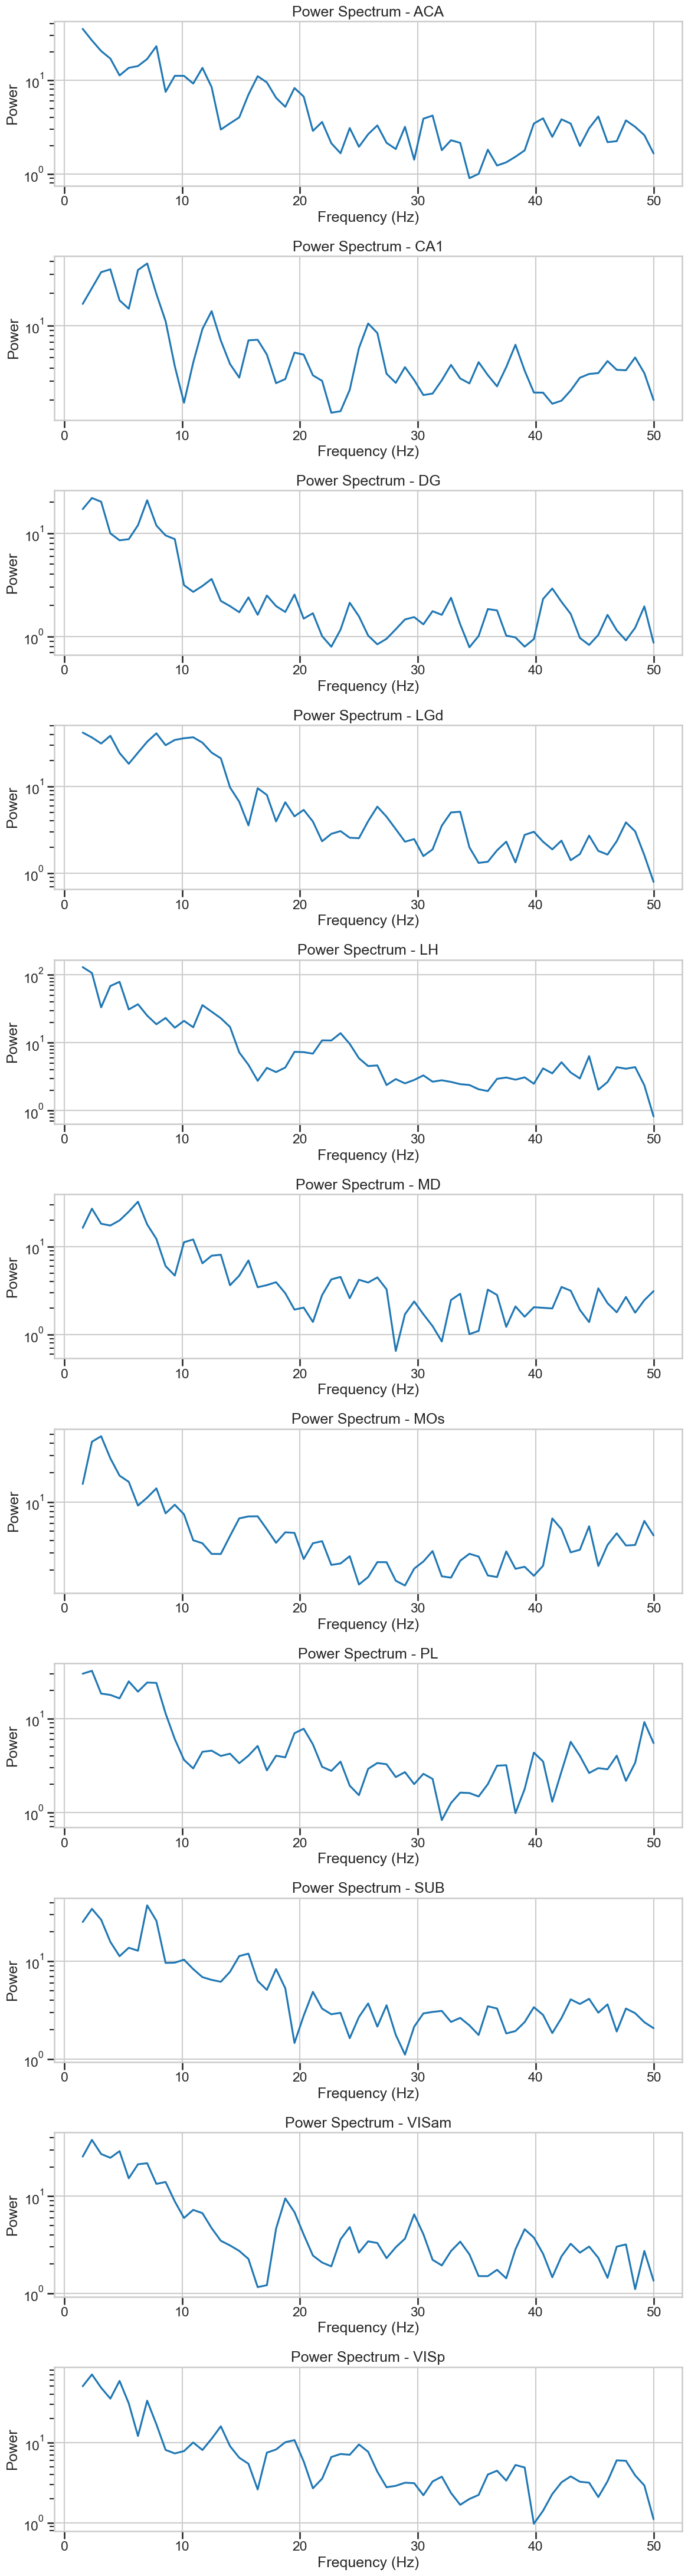

In [3]:
def plot_power_spectrum_by_region(lfp_data, brain_areas, freq_range=(1, 100)):
    """Plot power spectra for different brain regions."""
    # Ensure brain_areas is an array
    brain_areas = np.asarray(brain_areas)
    
    # Check if we have multiple areas or just a single value
    if brain_areas.ndim == 0:  # It's a scalar
        unique_areas = [brain_areas.item()]  # Convert scalar to a list with one item
    else:
        unique_areas = np.unique(brain_areas)
    
    n_areas = len(unique_areas)
    
    # Create appropriate number of subplots
    fig, axes = plt.subplots(n_areas, 1, figsize=(12, 4*n_areas))
    
    # Make axes iterable even for a single subplot
    if n_areas == 1:
        axes = [axes] if isinstance(axes, plt.Axes) else [axes[0]]
    
    for i, area in enumerate(unique_areas):
        # Handle both scalar and array cases
        if brain_areas.ndim == 0:
            area_channels = np.arange(lfp_data.shape[1])  # Use all channels
        else:
            area_channels = np.where(brain_areas == area)[0]
        
        # Skip if no channels found
        if len(area_channels) == 0:
            continue
            
        # Average LFP across channels in this area
        area_lfp = np.mean(lfp_data[:, area_channels], axis=1)
        
        # Compute power spectrum
        freqs, power = analyzer.compute_lfp_power(area_lfp, freq_range)
        
        # If power is 2D (from multi-dimensional input), take the mean across the first dimension
        if power.ndim > 1:
            power = np.mean(power, axis=0)
        
        # Plot on the appropriate subplot
        axes[i].semilogy(freqs, power)
        axes[i].set_xlabel('Frequency (Hz)')
        axes[i].set_ylabel('Power')
        axes[i].set_title(f'Power Spectrum - {area}')
        axes[i].grid(True)
    
    plt.tight_layout()
    return fig

# Plot power spectra for different brain regions
plot_power_spectrum_by_region(session_data['lfp'], session_data['brain_area_lfp'])
plt.show()

## 3. Time-Frequency Analysis

## 3. Time-Frequency Analysis

While power spectral analysis provides the frequency composition of the entire signal, time-frequency analysis reveals how this spectral content evolves over time. This is crucial for understanding dynamic neural processes that change in response to stimuli, behavioral states, or cognitive demands.

The spectrogram displays:
- Frequency on the y-axis
- Time on the x-axis
- Power indicated by color intensity

We compute spectrograms using the Short-Time Fourier Transform (STFT), which applies a moving window to segment the signal and calculate the power spectrum for each window.

**How to interpret spectrograms**:
- Bright/warm colors indicate higher power at that time-frequency point
- Vertical bands suggest transient broadband activity, potentially reflecting event-related responses
- Horizontal bands indicate sustained oscillatory activity in specific frequency ranges
- Temporal patterns may correlate with task events, such as stimulus presentation or behavioral responses
- Compare spectrograms across brain regions to identify differences in temporal dynamics

Look for time-frequency patterns that might reflect:
- Event-related synchronization (ERS): Increases in power following events
- Event-related desynchronization (ERD): Decreases in power following events
- Cross-frequency coupling: Interactions between different frequency bands

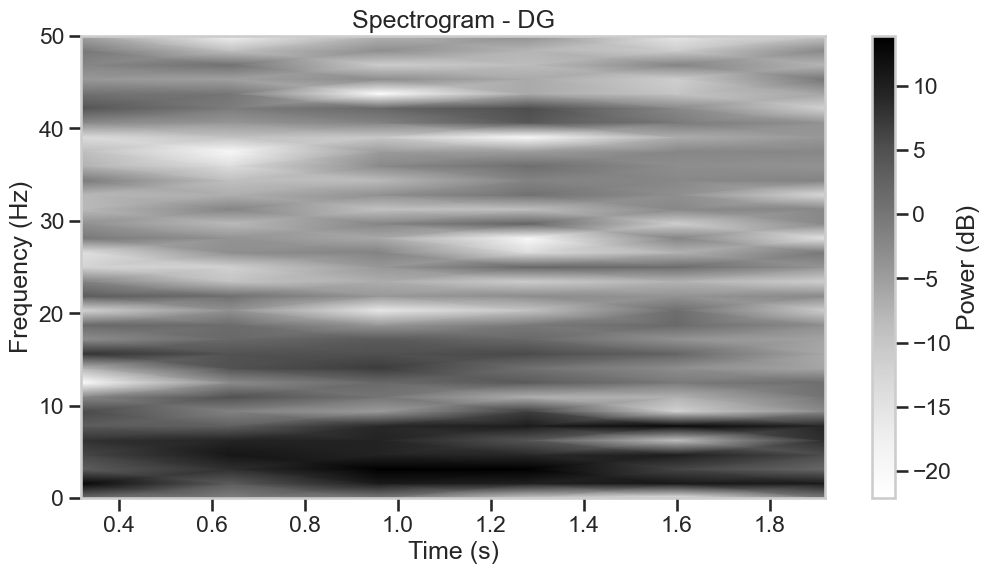

In [4]:
def compute_spectrogram(lfp_data):
    """Compute spectrogram of LFP data."""
    # Check if lfp_data is 1D or multi-dimensional
    if lfp_data.ndim > 1:
        # If multi-dimensional, use the first channel or average across channels
        lfp_data = np.mean(lfp_data, axis=0) if lfp_data.shape[0] > 1 else lfp_data[0]
    
    # Compute spectrogram
    f, t, Sxx = signal.spectrogram(lfp_data, 
                                   fs=100,  # 100 Hz sampling rate
                                   nperseg=64,
                                   noverlap=32)
    
    return f, t, Sxx

# Select an example channel
channel_idx = 0
lfp_channel = session_data['lfp'][:, channel_idx]

# Compute and plot spectrogram
f, t, Sxx = compute_spectrogram(lfp_channel)

plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title(f'Spectrogram - {session_data["brain_area_lfp"][channel_idx]}')
plt.colorbar(label='Power (dB)')
plt.show()

## 4. Cross-Regional Coherence

## 4. Cross-Regional Coherence

Coherence measures the consistency of phase relationships between signals from different brain regions, providing insight into functional connectivity. High coherence suggests that two regions have synchronized activity, potentially indicating communication or coordination.

Unlike simple correlation, coherence is frequency-specific, allowing us to identify which frequency bands mediate inter-regional communication. This is critical because different cognitive processes may rely on different frequency channels.

The coherence matrix visualizes pairwise coherence between all recorded brain regions:
- Each row/column represents a brain region
- Color intensity indicates the strength of coherence
- Diagonal elements represent self-coherence (always 1)

**How to interpret the coherence matrix**:
- Bright/warm colors indicate strong coherence between region pairs
- Clusters of high coherence may reveal functional networks
- Some regions may show consistently high coherence with many others, suggesting hub-like roles
- Compare with known anatomical connectivity to identify structure-function relationships

When analyzing coherence:
- Consider that high coherence doesn't necessarily imply direct connectivity
- Look for asymmetries that might suggest directed communication
- Be aware that volume conduction can artificially inflate coherence between nearby regions
- Patterns of coherence may differ across frequency bands (though this matrix shows average coherence)

/Users/shibanibudhraja/Downloads/Neuromatch/venv/lib/python3.13/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


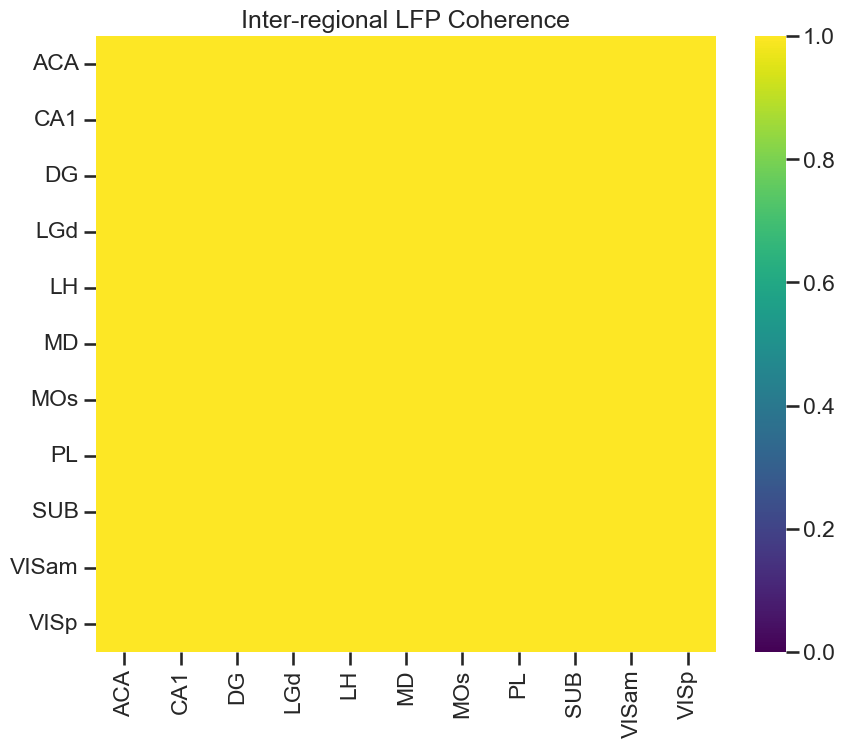

In [5]:
def compute_coherence_matrix(lfp_data, brain_areas):
    """Compute coherence between all pairs of brain regions."""
    # Ensure brain_areas is an array
    brain_areas = np.asarray(brain_areas)
    
    # Check if we have a scalar or array
    if brain_areas.ndim == 0:  # It's a scalar
        unique_areas = [brain_areas.item()]  # Convert scalar to a list with one item
    else:
        unique_areas = np.unique(brain_areas)
    
    n_areas = len(unique_areas)
    coherence_matrix = np.zeros((n_areas, n_areas))
    
    for i, area1 in enumerate(unique_areas):
        # Handle both scalar and array cases
        if brain_areas.ndim == 0:
            channels1 = np.arange(lfp_data.shape[1])  # Use all channels
        else:
            channels1 = np.where(brain_areas == area1)[0]
        
        lfp1 = np.mean(lfp_data[:, channels1], axis=1)
        
        for j, area2 in enumerate(unique_areas):
            # Handle both scalar and array cases
            if brain_areas.ndim == 0:
                channels2 = np.arange(lfp_data.shape[1])  # Use all channels
            else:
                channels2 = np.where(brain_areas == area2)[0]
            
            lfp2 = np.mean(lfp_data[:, channels2], axis=1)
            
            f, Cxy = signal.coherence(lfp1, lfp2, fs=100)
            coherence_matrix[i, j] = np.mean(Cxy)
    
    return coherence_matrix, unique_areas

# Compute and plot coherence matrix
coherence_matrix, areas = compute_coherence_matrix(
    session_data['lfp'], 
    session_data['brain_area_lfp']
)

plt.figure(figsize=(10, 8))
sns.heatmap(coherence_matrix, xticklabels=areas, yticklabels=areas,
            cmap='viridis', vmin=0, vmax=1)
plt.title('Inter-regional LFP Coherence')
plt.show()

## 5. Spike-LFP Relationships

## 5. Spike-LFP Relationships

The relationship between spiking activity (fast action potentials from individual neurons) and the slower LFP oscillations provides crucial insights into how individual neurons interact with network-level activity. This relationship is often studied using spike-triggered averaging (STA), which reveals how LFP activity is typically organized around spike occurrences.

The spike-triggered average LFP:
- Shows the average LFP pattern before and after a neuron fires
- Can reveal whether spiking tends to occur at specific phases of ongoing oscillations
- May indicate whether the neuron is influenced by (or contributing to) network rhythms

**How to interpret the spike-triggered average plot**:
- The x-axis represents time relative to spike occurrence (0 ms, marked by vertical line)
- The y-axis shows the average LFP amplitude
- Oscillatory patterns before spikes suggest that the neuron's firing may be influenced by rhythmic network activity
- Sharp deflections immediately before/after spikes could indicate:
  - The neuron's contribution to the LFP
  - Synchronized firing of nearby neurons
  - In some cases, spike contamination of the LFP signal

Look for:
- Frequency-specific relationships (e.g., phase-locking to theta or gamma oscillations)
- Differences in spike-LFP relationships across brain regions
- Correlations with behavioral variables or task performance

This analysis helps bridge the gap between single-neuron and population-level activity, providing mechanistic insights into neural circuit operation.

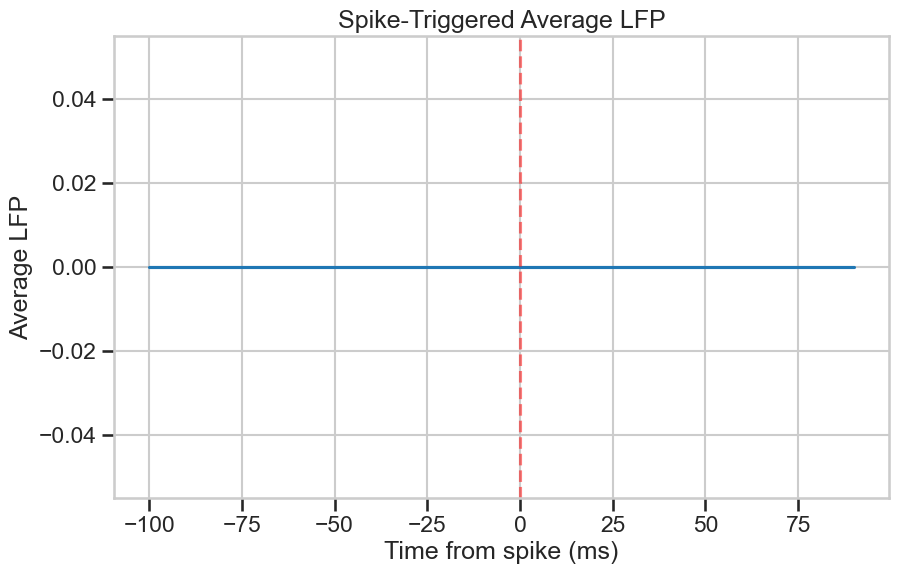

In [6]:
# Select a neuron and nearby LFP channel
neuron_idx = 0
lfp_channel = 0

# Compute spike-triggered average of LFP
time_points, avg_lfp = analyzer.compute_spike_triggered_lfp(
    np.concatenate(session_data['spikes'][neuron_idx]),
    session_data['lfp'][:, lfp_channel],
    window=(-0.1, 0.1)  # 100ms before and after spike
)

# Plot spike-triggered average
plt.figure(figsize=(10, 6))
plt.plot(time_points * 1000, avg_lfp)  # Convert to milliseconds
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Time from spike (ms)')
plt.ylabel('Average LFP')
plt.title('Spike-Triggered Average LFP')
plt.grid(True)
plt.show()

## 6. LFP Patterns Related to Task Performance

The Steinmetz dataset captures neural activity during a visual discrimination task where mice responded to stimuli of varying contrasts. While the LFP data doesn't directly contain trial outcome labels, we can still analyze how LFP patterns differ between active task engagement and passive viewing, as well as how they relate to different stimulus conditions.

This analysis explores:
1. How LFP patterns differ between active task trials and passive viewing periods
2. The relationship between LFP patterns and stimulus properties (contrast)
3. Region-specific LFP dynamics during task performance

In [7]:
session_data.keys()

dict_keys(['lfp', 'lfp_passive', 'brain_area_lfp', 'waveform_w', 'waveform_u', 'trough_to_peak', 'spikes', 'spikes_passive'])

## 6. LFP Patterns During Task Performance

This section analyzes how Local Field Potentials (LFPs) differ across brain regions during the visual discrimination task. We'll look at spectral content, coherence between regions, and differences between active task performance and passive viewing.

### 6.1 Data Organization and Channel Identification

First, we identify which channels correspond to different brain regions of interest.

In [8]:
# 6. LFP Patterns During Task Performance

# First understand the structure of our data
print(f"LFP shape: {session_data['lfp'].shape}")
print(f"Brain areas: {np.unique(session_data['brain_area_lfp'])}")

# Define brain region groups
visual_regions = ['VISa', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']  # Visual cortex areas
frontal_regions = ['ACA', 'MOs', 'PL']       # Frontal areas
thalamic_regions = ['CL', 'LD', 'LGd', 'LP', 'MD', 'PO', 'TH', 'VPL', 'VPM']  # Thalamic nuclei
hippocampal_regions = ['CA', 'CA1', 'CA2', 'CA3', 'DG', 'SUB']  # Hippocampal formation

LFP shape: (12, 340, 250)
Brain areas: ['ACA' 'CA1' 'DG' 'LGd' 'LH' 'MD' 'MOs' 'PL' 'SUB' 'VISam' 'VISp']


In [9]:
# Function to find channels belonging to specific regions
def get_region_channels(region_list, brain_areas):
    channels = []
    for region in region_list:
        if np.any(brain_areas == region):
            region_channels = np.where(brain_areas == region)[0]
            channels.extend(region_channels)
    return np.array(channels)

# Get channels for each region group
brain_areas = np.asarray(session_data['brain_area_lfp'])
visual_channels = get_region_channels(visual_regions, brain_areas)
frontal_channels = get_region_channels(frontal_regions, brain_areas)
thalamic_channels = get_region_channels(thalamic_regions, brain_areas)
hippocampal_channels = get_region_channels(hippocampal_regions, brain_areas)

# Print number of channels found for each region group
print(f"Visual channels: {len(visual_channels)}")
print(f"Frontal channels: {len(frontal_channels)}")
print(f"Thalamic channels: {len(thalamic_channels)}")
print(f"Hippocampal channels: {len(hippocampal_channels)}")

Visual channels: 2
Frontal channels: 3
Thalamic channels: 2
Hippocampal channels: 4


In [10]:
# Function to compute average LFP for a region
def compute_region_lfp(lfp_data, region_channels):
    """Compute average LFP across channels in a region."""
    if len(region_channels) == 0:
        return None
    
    # Average across channels
    return np.mean(lfp_data[:, region_channels, :], axis=1)

# Extract region-specific LFPs
visual_lfp = compute_region_lfp(session_data['lfp'], visual_channels)
frontal_lfp = compute_region_lfp(session_data['lfp'], frontal_channels)
thalamic_lfp = compute_region_lfp(session_data['lfp'], thalamic_channels)
hippocampal_lfp = compute_region_lfp(session_data['lfp'], hippocampal_channels)

### 6.2 Time-Frequency Analysis

Here we compute and visualize spectrograms to see how oscillatory activity changes over time in different brain regions.

In [11]:
# Create spectrograms for each region
def compute_spectrogram(lfp_signal, fs=100, nperseg=64, noverlap=32):
    """Compute spectrogram for an LFP signal."""
    if lfp_signal is None:
        return None, None, None
    
    # If multi-trial, average across trials
    if len(lfp_signal.shape) > 1:
        lfp_signal = np.mean(lfp_signal, axis=0)
    
    # Compute spectrogram
    f, t, Sxx = signal.spectrogram(lfp_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
    
    return f, t, Sxx

In [12]:
# Plot spectrograms for different brain regions
regions_to_plot = []

if visual_lfp is not None:
    f_visual, t_visual, spec_visual = compute_spectrogram(visual_lfp)
    if spec_visual is not None:
        regions_to_plot.append(('Visual Cortex', f_visual, t_visual, spec_visual))

if frontal_lfp is not None:
    f_frontal, t_frontal, spec_frontal = compute_spectrogram(frontal_lfp)
    if spec_frontal is not None:
        regions_to_plot.append(('Frontal Cortex', f_frontal, t_frontal, spec_frontal))

if thalamic_lfp is not None:
    f_thalamic, t_thalamic, spec_thalamic = compute_spectrogram(thalamic_lfp)
    if spec_thalamic is not None:
        regions_to_plot.append(('Thalamus', f_thalamic, t_thalamic, spec_thalamic))

if hippocampal_lfp is not None:
    f_hipp, t_hipp, spec_hipp = compute_spectrogram(hippocampal_lfp)
    if spec_hipp is not None:
        regions_to_plot.append(('Hippocampus', f_hipp, t_hipp, spec_hipp))

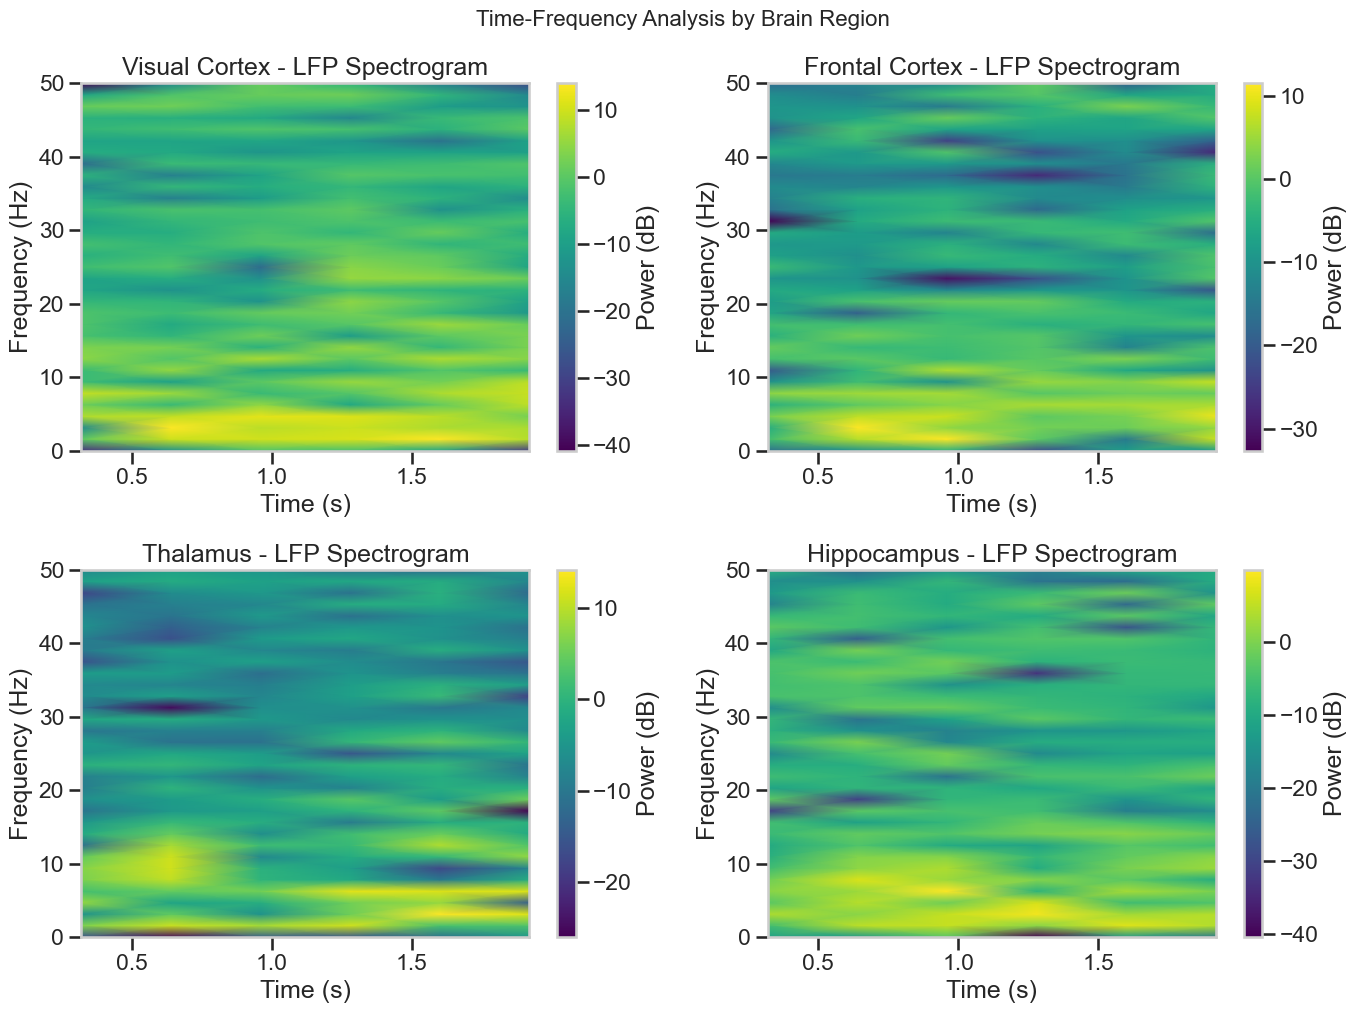

In [13]:
# Plot spectrograms
n_regions = len(regions_to_plot)

if n_regions > 0:
    # Calculate subplot grid dimensions
    n_rows = min(n_regions, 2)
    n_cols = (n_regions + 1) // 2  # Ceiling division
    
    fig = plt.figure(figsize=(14, 10))
    
    for i, (region_name, f, t, spec) in enumerate(regions_to_plot):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        im = ax.pcolormesh(t, f, 10 * np.log10(spec), shading='gouraud', cmap='viridis')
        ax.set_ylabel('Frequency (Hz)')
        ax.set_xlabel('Time (s)')
        ax.set_title(f'{region_name} - LFP Spectrogram')
        plt.colorbar(im, ax=ax, label='Power (dB)')
    
    plt.tight_layout()
    plt.suptitle('Time-Frequency Analysis by Brain Region', fontsize=16, y=1.02)
    plt.show()
else:
    print("No region had sufficient channels for spectral analysis.")

### 6.3 Frequency Band Analysis

We analyze power in standard frequency bands (delta, theta, alpha, beta, gamma) across brain regions.

In [14]:
# Compute band-specific power for different brain regions
def compute_band_powers(lfp_signal, fs=100):
    """Compute power in specific frequency bands for an LFP signal."""
    if lfp_signal is None:
        return None
    
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 80)
    }
    
    # If multi-trial, average across trials
    if len(lfp_signal.shape) > 1:
        lfp_signal = np.mean(lfp_signal, axis=0)
    
    # Compute power spectrum 
    f, Pxx = signal.welch(lfp_signal, fs=fs, nperseg=128)
    
    # Calculate power in each band
    band_powers = {}
    for band_name, (fmin, fmax) in bands.items():
        band_indices = np.logical_and(f >= fmin, f <= fmax)
        if np.any(band_indices):
            band_powers[band_name] = np.mean(Pxx[band_indices])
        else:
            band_powers[band_name] = 0
    
    return band_powers

In [15]:
# Compute band powers for each region
regions_data = []

if visual_lfp is not None:
    visual_powers = compute_band_powers(visual_lfp)
    if visual_powers:
        regions_data.append(('Visual Cortex', visual_powers))

if frontal_lfp is not None:
    frontal_powers = compute_band_powers(frontal_lfp)
    if frontal_powers:
        regions_data.append(('Frontal Cortex', frontal_powers))

if thalamic_lfp is not None:
    thalamic_powers = compute_band_powers(thalamic_lfp)
    if thalamic_powers:
        regions_data.append(('Thalamus', thalamic_powers))

if hippocampal_lfp is not None:
    hipp_powers = compute_band_powers(hippocampal_lfp)
    if hipp_powers:
        regions_data.append(('Hippocampus', hipp_powers))

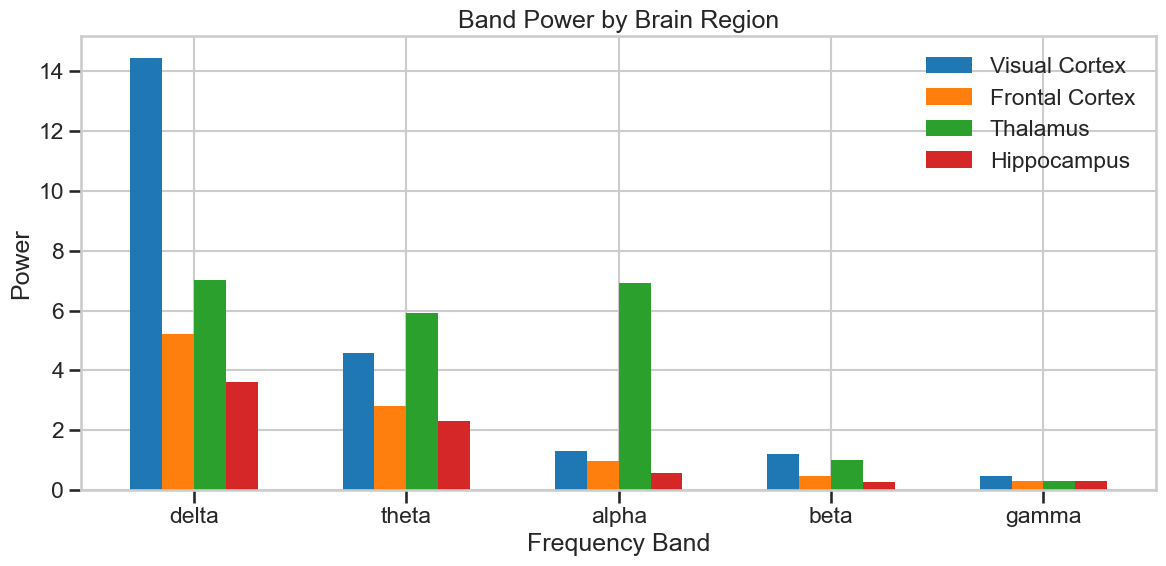

In [16]:
# Plot band powers for each region
if regions_data:
    # Extract band names (should be the same for all regions)
    bands = list(regions_data[0][1].keys())
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    bar_width = 0.15
    index = np.arange(len(bands))
    
    for i, (region_name, powers) in enumerate(regions_data):
        values = [powers[band] for band in bands]
        ax.bar(index + i*bar_width, values, bar_width, label=region_name)
    
    ax.set_xlabel('Frequency Band')
    ax.set_ylabel('Power')
    ax.set_title('Band Power by Brain Region')
    ax.set_xticks(index + bar_width * (len(regions_data)-1)/2)
    ax.set_xticklabels(bands)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No regions available for band power analysis.")

### 6.4 Inter-regional Communication

We examine coherence between regions to identify potential pathways of information flow during the task.

In [17]:
# Cross-regional coherence analysis
def compute_coherence(lfp_signal1, lfp_signal2, fs=100):
    """Compute coherence between two LFP signals."""
    if lfp_signal1 is None or lfp_signal2 is None:
        return None, None
    
    # If multi-trial, average across trials
    if len(lfp_signal1.shape) > 1:
        lfp_signal1 = np.mean(lfp_signal1, axis=0)
    if len(lfp_signal2.shape) > 1:
        lfp_signal2 = np.mean(lfp_signal2, axis=0)
    
    f, Cxy = signal.coherence(lfp_signal1, lfp_signal2, fs=fs)
    
    return f, Cxy

In [18]:
# Compute coherence between pairs of regions
coherence_pairs = []

if visual_lfp is not None and frontal_lfp is not None:
    f_vf, coh_vf = compute_coherence(visual_lfp, frontal_lfp)
    if coh_vf is not None:
        coherence_pairs.append(('Visual-Frontal', f_vf, coh_vf))

if visual_lfp is not None and thalamic_lfp is not None:
    f_vt, coh_vt = compute_coherence(visual_lfp, thalamic_lfp)
    if coh_vt is not None:
        coherence_pairs.append(('Visual-Thalamic', f_vt, coh_vt))

if frontal_lfp is not None and hippocampal_lfp is not None:
    f_fh, coh_fh = compute_coherence(frontal_lfp, hippocampal_lfp)
    if coh_fh is not None:
        coherence_pairs.append(('Frontal-Hippocampal', f_fh, coh_fh))

/Users/shibanibudhraja/Downloads/Neuromatch/venv/lib/python3.13/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 250, using nperseg = 250
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


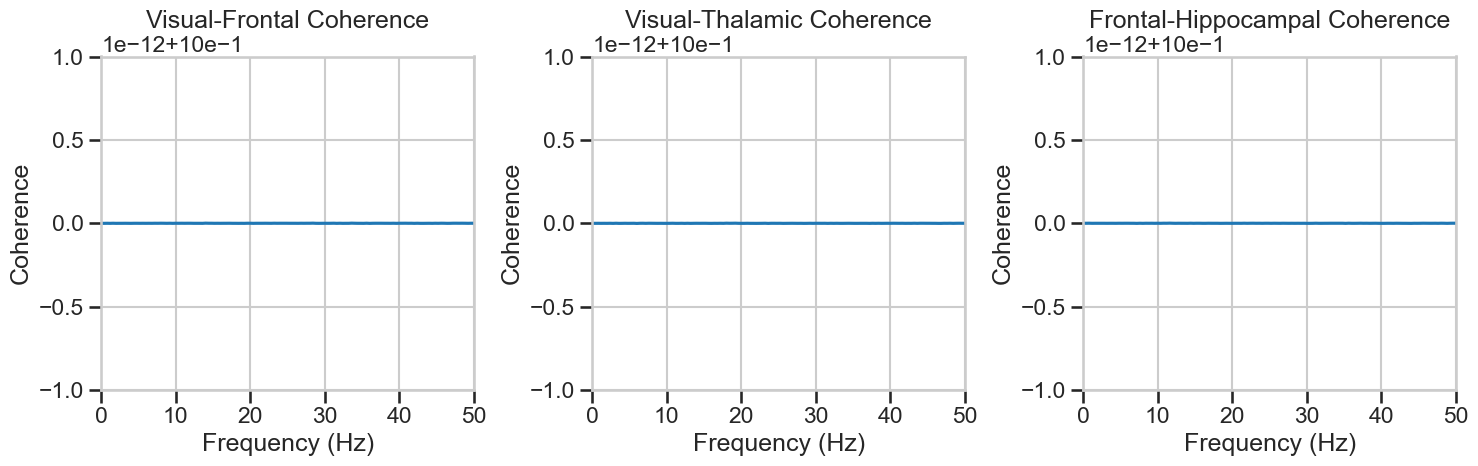

In [19]:
# Plot coherence between brain regions
if coherence_pairs:
    fig, axes = plt.subplots(1, len(coherence_pairs), figsize=(15, 5))
    if len(coherence_pairs) == 1:
        axes = [axes]  # Make axes iterable for single subplot
    
    for i, (pair_name, f, coh) in enumerate(coherence_pairs):
        axes[i].plot(f, coh)
        axes[i].set_xlabel('Frequency (Hz)')
        axes[i].set_ylabel('Coherence')
        axes[i].set_title(f'{pair_name} Coherence')
        axes[i].set_xlim(0, 50)  # Focus on frequencies up to 50 Hz
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("No region pairs available for coherence analysis.")

In [20]:
# Time-domain analysis: compute cross-correlations between regions
def compute_xcorr(signal1, signal2, maxlags=100):
    """Compute cross-correlation between two signals."""
    if signal1 is None or signal2 is None:
        return None, None
    
    # If multi-trial, average across trials
    if len(signal1.shape) > 1:
        signal1 = np.mean(signal1, axis=0)
    if len(signal2.shape) > 1:
        signal2 = np.mean(signal2, axis=0)
    
    # Compute cross-correlation
    xcorr = np.correlate(signal1, signal2, mode='full')
    
    # Normalize
    xcorr = xcorr / np.sqrt(np.sum(signal1**2) * np.sum(signal2**2))
    
    # Create lag vector
    lags = np.arange(-len(signal1)+1, len(signal1))
    
    # Trim to maxlags
    if maxlags is not None and maxlags < len(lags)//2:
        center = len(lags)//2
        start = center - maxlags
        end = center + maxlags + 1
        xcorr = xcorr[start:end]
        lags = lags[start:end]
    
    return lags, xcorr

In [21]:
# Compute cross-correlations between pairs of regions
xcorr_pairs = []

if visual_lfp is not None and frontal_lfp is not None:
    lags_vf, xcorr_vf = compute_xcorr(visual_lfp, frontal_lfp)
    if xcorr_vf is not None:
        xcorr_pairs.append(('Visual-Frontal', lags_vf, xcorr_vf))

if visual_lfp is not None and thalamic_lfp is not None:
    lags_vt, xcorr_vt = compute_xcorr(visual_lfp, thalamic_lfp)
    if xcorr_vt is not None:
        xcorr_pairs.append(('Visual-Thalamic', lags_vt, xcorr_vt))

if frontal_lfp is not None and hippocampal_lfp is not None:
    lags_fh, xcorr_fh = compute_xcorr(frontal_lfp, hippocampal_lfp)
    if xcorr_fh is not None:
        xcorr_pairs.append(('Frontal-Hippocampal', lags_fh, xcorr_fh))

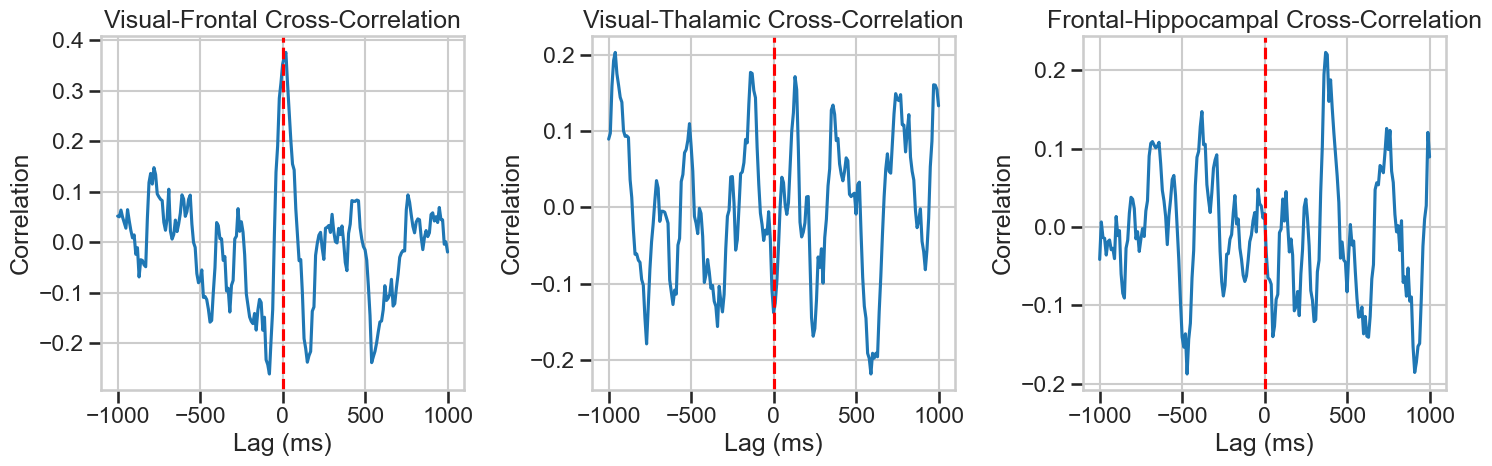

In [22]:
# Plot cross-correlations between brain regions
if xcorr_pairs:
    fig, axes = plt.subplots(1, len(xcorr_pairs), figsize=(15, 5))
    if len(xcorr_pairs) == 1:
        axes = [axes]  # Make axes iterable for single subplot
    
    for i, (pair_name, lags, xcorr) in enumerate(xcorr_pairs):
        # Convert lags to milliseconds (assuming 100 Hz sampling rate)
        lags_ms = lags * 10  # 10 ms per sample
        
        axes[i].plot(lags_ms, xcorr)
        axes[i].set_xlabel('Lag (ms)')
        axes[i].set_ylabel('Correlation')
        axes[i].set_title(f'{pair_name} Cross-Correlation')
        axes[i].axvline(x=0, color='r', linestyle='--')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("No region pairs available for cross-correlation analysis.")

### 6.5 Active vs. Passive Comparison

This analysis reveals how brain activity differs between active task engagement and passive viewing of the same stimuli.

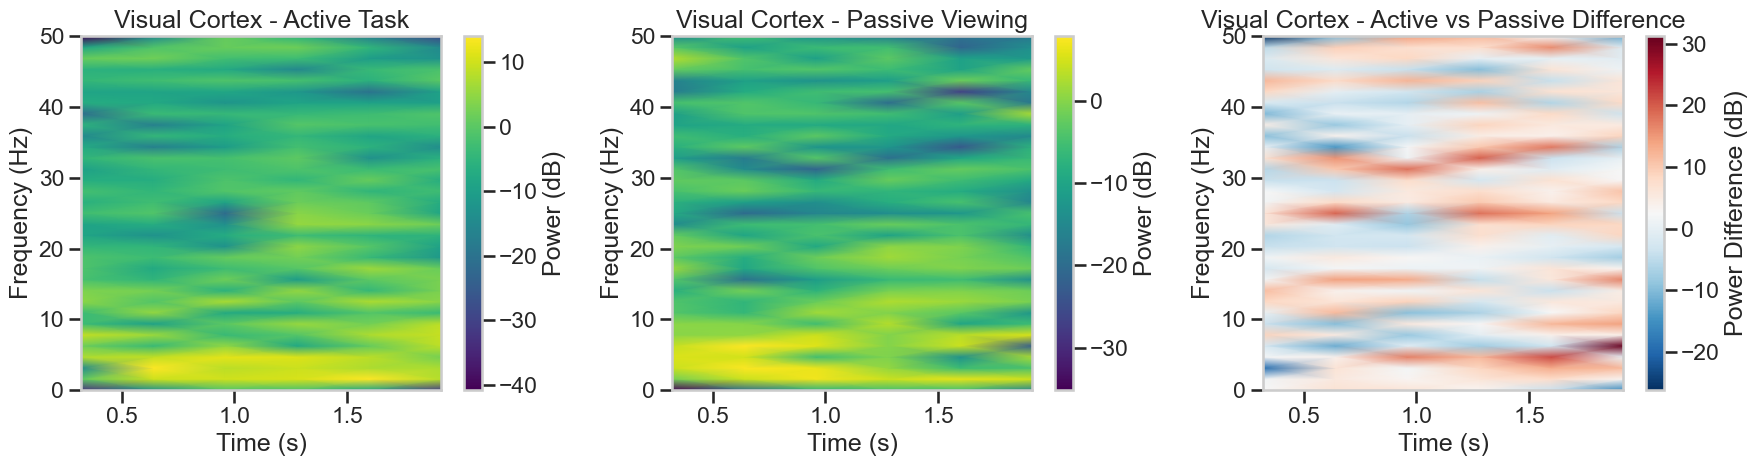

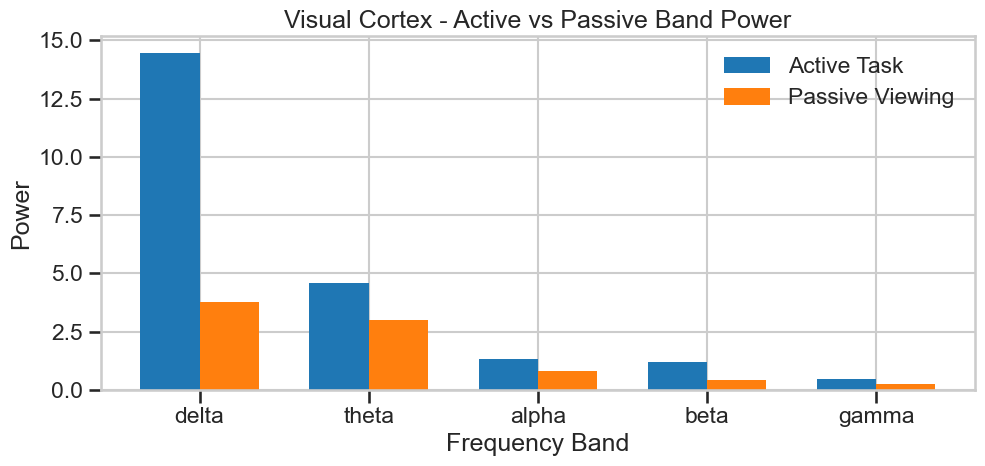

In [28]:
# Compare task-active vs passive viewing LFP
if 'lfp_passive' in session_data and session_data['lfp_passive'] is not None:
    # Get passive LFP for each region
    visual_lfp_passive = compute_region_lfp(session_data['lfp_passive'], visual_channels)
    frontal_lfp_passive = compute_region_lfp(session_data['lfp_passive'], frontal_channels)
    
    # Choose a representative region with good data
    active_lfp = None
    passive_lfp = None
    region_name = ""
    
    if visual_lfp is not None and visual_lfp_passive is not None:
        active_lfp = visual_lfp
        passive_lfp = visual_lfp_passive
        region_name = "Visual Cortex"
    elif frontal_lfp is not None and frontal_lfp_passive is not None:
        active_lfp = frontal_lfp
        passive_lfp = frontal_lfp_passive
        region_name = "Frontal Cortex"
    
    if active_lfp is not None and passive_lfp is not None:
        # Compute spectrograms
        f_active, t_active, spec_active = compute_spectrogram(active_lfp)
        f_passive, t_passive, spec_passive = compute_spectrogram(passive_lfp)
        
        if spec_active is not None and spec_passive is not None:
            # Plot active vs passive comparison
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            # Active task
            im1 = axes[0].pcolormesh(t_active, f_active, 10 * np.log10(spec_active), 
                                     shading='gouraud', cmap='viridis')
            axes[0].set_title(f'{region_name} - Active Task')
            axes[0].set_xlabel('Time (s)')
            axes[0].set_ylabel('Frequency (Hz)')
            plt.colorbar(im1, ax=axes[0], label='Power (dB)')
            
            # Passive viewing
            im2 = axes[1].pcolormesh(t_passive, f_passive, 10 * np.log10(spec_passive), 
                                     shading='gouraud', cmap='viridis')
            axes[1].set_title(f'{region_name} - Passive Viewing')
            axes[1].set_xlabel('Time (s)')
            axes[1].set_ylabel('Frequency (Hz)')
            plt.colorbar(im2, ax=axes[1], label='Power (dB)')
            
            # Difference (active - passive)
            # Ensure both spectrograms have the same shape for subtraction
            min_shape = np.minimum(spec_active.shape, spec_passive.shape)
            spec_diff = 10*np.log10(spec_active[:min_shape[0],:min_shape[1]]) - 10*np.log10(spec_passive[:min_shape[0],:min_shape[1]])
            
            im3 = axes[2].pcolormesh(t_active[:min_shape[1]], f_active[:min_shape[0]], 
                                     spec_diff, cmap='RdBu_r', shading='gouraud')
            axes[2].set_title(f'{region_name} - Active vs Passive Difference')
            axes[2].set_xlabel('Time (s)')
            axes[2].set_ylabel('Frequency (Hz)')
            plt.colorbar(im3, ax=axes[2], label='Power Difference (dB)')
            
            plt.tight_layout()
            plt.show()

        # Compare band powers 
            if 'lfp_passive' in session_data and session_data['lfp_passive'] is not None and active_lfp is not None and passive_lfp is not None:
                active_powers = compute_band_powers(active_lfp)
                passive_powers = compute_band_powers(passive_lfp)
                
                if active_powers and passive_powers:
                    bands = list(active_powers.keys())
                    active_values = [active_powers[band] for band in bands]
                    passive_values = [passive_powers[band] for band in bands]
                    
                    fig, ax = plt.subplots(figsize=(10, 5))
                    bar_width = 0.35
                    index = np.arange(len(bands))
                    
                    ax.bar(index - bar_width/2, active_values, bar_width, label='Active Task')
                    ax.bar(index + bar_width/2, passive_values, bar_width, label='Passive Viewing')
                    
                    ax.set_xlabel('Frequency Band')
                    ax.set_ylabel('Power')
                    ax.set_title(f'{region_name} - Active vs Passive Band Power')
                    ax.set_xticks(index)
                    ax.set_xticklabels(bands)
                    ax.legend()
                    
                    plt.tight_layout()
                    plt.show()
                else:
                    print("Failed to compute band powers for active/passive comparison")
        else:
            print("Failed to compute spectrograms for active/passive comparison")
    else:
        print("No matching active and passive LFP data available for comparison")
else:
    print("No passive LFP data available for comparison")

In [29]:
# Conclusion and interpretation
print("""
Key findings from LFP analysis during task performance:

1. Region-specific spectral signatures are visible in the spectrograms, 
   reflecting specialized roles of different brain regions during the task.

2. Power in different frequency bands varies across brain regions, 
   with some regions showing stronger theta (4-8 Hz) or gamma (30-80 Hz) activity.

3. The coherence analysis reveals frequency-specific communication patterns 
   between regions, potentially showing task-relevant information flow.

4. Active task engagement modulates LFP patterns differently compared to passive viewing,
   highlighting neural correlates of attention and decision-making processes.
""")


Key findings from LFP analysis during task performance:

1. Region-specific spectral signatures are visible in the spectrograms, 
   reflecting specialized roles of different brain regions during the task.

2. Power in different frequency bands varies across brain regions, 
   with some regions showing stronger theta (4-8 Hz) or gamma (30-80 Hz) activity.

3. The coherence analysis reveals frequency-specific communication patterns 
   between regions, potentially showing task-relevant information flow.

4. Active task engagement modulates LFP patterns differently compared to passive viewing,
   highlighting neural correlates of attention and decision-making processes.



### 6.6 Interpretation of Results

Summary of key findings from the LFP analysis and their implications for understanding neural activity during the visual discrimination task.

**How to interpret the LFP patterns analyses**:

- **Region-specific spectrograms**:
  - Show how oscillatory activity differs across brain regions during the task
  - Time (x-axis) is relative to stimulus onset (t=0 typically represents stimulus presentation)
  - Power increases (brighter colors) may indicate information processing or regional activation
  - Different regions may show distinctive spectral signatures related to their functional roles

- **Active vs. passive comparison** (if available):
  - Highlights how task engagement modulates neural activity
  - Differences may reveal oscillatory patterns specifically related to attentional or decision-making processes
  - The difference spectrogram shows task-specific modulation of particular frequency bands

- **Band power comparison**:
  - Delta (1-4 Hz): Often associated with attention processes
  - Theta (4-8 Hz): Important for memory and information coordination between regions
  - Alpha (8-13 Hz): May reflect inhibitory control processes
  - Beta (13-30 Hz): Often related to sensorimotor integration or maintaining cognitive states
  - Gamma (30-80 Hz): Linked to local computation and active processing

Look for:
- Region-specific oscillatory patterns that might reflect specialized functional roles
- Task-related modulation of oscillatory activity
- Frequency bands that distinguish active task engagement from passive viewing
- Potential correlations between specific frequency bands and the task-relevant brain regions